In [2]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix


In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
scaler = RobustScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df.drop(['Time', 'Amount'], axis = 1, inplace = True)

In [6]:
normal_df = df[df.Class == 0]
fraud_df = df[df.Class == 1]

In [7]:
# We discard label for training 
X_normal = normal_df.drop(['Class'], axis = 1).values
X_fraud = fraud_df.drop(['Class'], axis = 1).values

In [8]:
X_train, X_test_normal = train_test_split(X_normal, test_size = 0.2, random_state = 42)

In [9]:
X_test = np.concatenate([X_test_normal, X_fraud])
y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(X_fraud))])

In [10]:
# Converting NumPy matrices to PyTorch tensors
train_tensor = torch.tensor(X_train).float()
test_tensor = torch.tensor(X_test).float()
test_labels = torch.tensor(y_test).float()

In [11]:
train_loader = DataLoader(TensorDataset(train_tensor), batch_size = 256, shuffle = True)
test_loader = DataLoader(TensorDataset(test_tensor, test_labels), batch_size = 256, shuffle = False)
print(f'Training on {len(X_train)} normal transactions, and testing on {len(X_test)} transactions, including {len(X_fraud)} frauds.')

Training on 227452 normal transactions, and testing on 57355 transactions, including 492 frauds.


In [12]:
class FraudAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(FraudAutoencoder, self).__init__()
        # Encoder 
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 14),
            nn.Tanh(),
            nn.Linear(14, 3),
            nn.LeakyReLU()    
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 14),
            nn.Tanh(),
            nn.Linear(14, input_dim)  
        )
    
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstructed = self.decoder(latent_code)
        return reconstructed

In [13]:
input_dimension = 29
model = FraudAutoencoder(input_dim = input_dimension)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [14]:
def train_model(model, train_loader, num_epochs = 20):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for data in train_loader:
            inputs = data[0]
            # Forward pass
            reconstructions = model(inputs)
            loss = criterion(reconstructions, inputs)
            # BackWard pass
            optimizer.zero_grad()
            loss.backward() # Computes Gradients (dL/dW)
            optimizer.step()
            total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Avg_Loss: {avg_loss:.4f}')

In [15]:
def detect_fraud(model, transaction_data, threshold): 
    model.eval()
    with torch.no_grad():
        reconstruction = model(transaction_data)
        loss = criterion(reconstruction, transaction_data)
        if loss.item() > threshold:
            return 'FRAUD DETECTED'
        else:
            return 'Normal' 

In [16]:
print('Starting Training...')
train_model(model, train_loader, num_epochs = 20)
print('Training Complete.')

Starting Training...
Epoch [1/20], Avg_Loss: 1.1083
Epoch [2/20], Avg_Loss: 0.8799
Epoch [3/20], Avg_Loss: 0.8092
Epoch [4/20], Avg_Loss: 0.7610
Epoch [5/20], Avg_Loss: 0.7218
Epoch [6/20], Avg_Loss: 0.6957
Epoch [7/20], Avg_Loss: 0.6773
Epoch [8/20], Avg_Loss: 0.6627
Epoch [9/20], Avg_Loss: 0.6504
Epoch [10/20], Avg_Loss: 0.6410
Epoch [11/20], Avg_Loss: 0.6328
Epoch [12/20], Avg_Loss: 0.6261
Epoch [13/20], Avg_Loss: 0.6202
Epoch [14/20], Avg_Loss: 0.6154
Epoch [15/20], Avg_Loss: 0.6119
Epoch [16/20], Avg_Loss: 0.6082
Epoch [17/20], Avg_Loss: 0.6045
Epoch [18/20], Avg_Loss: 0.6010
Epoch [19/20], Avg_Loss: 0.5980
Epoch [20/20], Avg_Loss: 0.5949
Training Complete.


In [17]:
model.eval()
reconstruction_errors = []

with torch.no_grad():
    for data in test_loader:
        inputs = data[0]
        # Forward pass
        reconstructed = model(inputs)
        # Calculate MSE loss for each individual transaction
        loss = torch.mean((inputs - reconstructed) ** 2, dim=1)
        reconstruction_errors.extend(loss.numpy())

# Threshold
precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_errors)

# Calculate F1 Score
numerator = 2 * (precision * recall)
denominator = (precision + recall)
f1_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)

# Find the threshold with the highest F1 score
best_f1_index = np.argmax(f1_scores[:-1])
best_threshold = thresholds[best_f1_index]
print(f"Optimal Threshold Found: {best_threshold:.4f}")

predictions = [1 if e > best_threshold else 0 for e in reconstruction_errors]

cm = confusion_matrix(y_test, predictions)
print('\n')
print('Confusion Matrix:','\n', cm)

Optimal Threshold Found: 8.1224


Confusion Matrix: 
 [[56666   197]
 [  187   305]]


In [20]:
threshold = 8.1224
index = 57000
real_transaction = test_tensor[index]
true_label = test_labels[index].item() # 0 = Normal, 1 = Fraud
decision = detect_fraud(model, real_transaction.unsqueeze(0), threshold)
print(f"Transaction Info: Actual Class = {'Fraud' if true_label == 1 else 'Normal'}")
print(f"Model Decision:   {decision}")

Transaction Info: Actual Class = Fraud
Model Decision:   FRAUD DETECTED


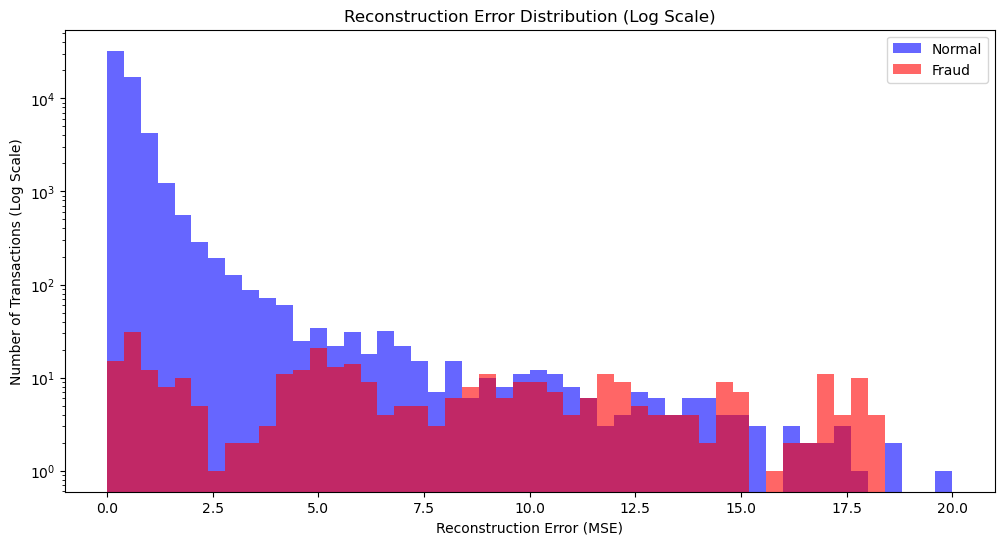

In [ ]:
# TO UNDERSTAND
import matplotlib.pyplot as plt
import numpy as np

# 1. Get the Reconstruction Errors
model.eval()
reconstruction_errors = []
true_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs = data[0]
        labels = data[1]  # We need labels now to color the graph!
        
        # Forward pass
        reconstructed = model(inputs)
        
        # Calculate MSE loss for each individual transaction
        # (Input - Output)^2, then average across the 29 features
        loss = torch.mean((inputs - reconstructed) ** 2, dim=1)
        
        reconstruction_errors.extend(loss.numpy())
        true_labels.extend(labels.numpy())

# Convert to numpy arrays for easier indexing
reconstruction_errors = np.array(reconstruction_errors)
true_labels = np.array(true_labels)

# 2. Plot the Histogram
plt.figure(figsize=(12, 6))
plt.title("Reconstruction Error Distribution (Log Scale)")

# Plot Normal Transactions (Label = 0)
plt.hist(reconstruction_errors[true_labels == 0], 
         bins=50, alpha=0.6, color='blue', label='Normal', range=(0, 20))

# Plot Fraud Transactions (Label = 1)
plt.hist(reconstruction_errors[true_labels == 1], 
         bins=50, alpha=0.6, color='red', label='Fraud', range=(0, 20))

# IMPORTANT: Log Scale allows us to see the tiny Fraud bars
plt.yscale('log') 
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Number of Transactions (Log Scale)")
plt.legend()
plt.show()